In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [3]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge,ProximityParent,ProximityCombo

import numpy as np
import matplotlib.pyplot as plt

## Data and operators

In [4]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(np.real(u0.data))+s*np.random.randn(2*n*n).view(np.complex128)
u0_mat = np.asarray(u0)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [49]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data

p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

new_loc = kspace_loc[np.where(p)]
#pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=4,padding_mode = "periodization")

In [6]:
#ifft on noised data = base result
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.6779040048898681


## CondatVu
### Regularizers
See modopt/opt/agorithms.py: Condat uses Moreau identity for prox_dual: we need to define the proximal operator and not the proximal dual.

In [7]:
class RegularizerG(ProximityParent):
    r"""negative values penalisation and L2 norm

    Parameters
    ----------
    linear : class
        Linear operator class
    weights : np.ndarray
        Input array of weights
    """

    def __init__(self, zeta, eps):
        self.weights = [eps,zeta]
        self.eps = eps
        self.zeta=zeta
        self.op = self._op_method
        self.cost = self._cost_method

        
    def _op_method(self, data, extra_factor=1.0):  
        thresh = self.eps*extra_factor
        
        return np.where(data>=0,data/(1+thresh),
                 data/(0.5+np.sqrt(0.25-3*self.zeta*extra_factor*data/(1+thresh)**2)))

    
    def _cost_method(self, *args, **kwargs):
        
        cost_val = np.abs(self.zeta*np.sum(np.where(args[0]<=0,-args[0]**3,0))
                           +self.eps*np.linalg.norm(args[0])**2/2)

        if 'verbose' in kwargs and kwargs['verbose']:
            print(' - G (X):', cost_val)

        return cost_val

In [50]:
class RegularizerF2(ProximityParent):
    r"""C2 approximation of an L1 norm

    Parameters
    ----------
    linear : class
        Linear operator class
    weights : np.ndarray
        Input array of weights
    """

    def __init__(self, linear, gamma, pn1):
        self.linear = linear
        self.weights = [gamma,pn1]
        self.gamma = gamma
        self.pn1=pn1
        self.op = self._op_method
        self.cost = self._cost_method
    
    def rho(self, x):
        m = np.abs(x)
        return np.where(m<self.gamma,-m**3/3/self.gamma**2+m**2/self.gamma,m-self.gamma/3)    
    
    def prox_J(self,x,c,gamma):
        return np.where(np.abs(x)>gamma+c,x*(1-c/np.abs(x)),
                    gamma*x/(c+0.5*gamma+np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))

        
    def _op_method(self, data, extra_factor=1.0):  
        return self.prox_J(data,self.pn1*extra_factor,self.gamma)
        
    
    def _cost_method(self, *args, **kwargs):
        
        cost_val = self.pn1*np.sum(self.rho(self.linear.op(args[0])))

        if 'verbose' in kwargs and kwargs['verbose']:
            print(' - F2 (X):', cost_val)

        return cost_val

In [51]:
zeta,epsilon,gamma,pn1 = 1e15,3e-5,1e-10,1e-6
regularizer_G = RegularizerG(zeta,epsilon)
regularizer_F2 = RegularizerF2(linear_op,gamma,pn1)

In [52]:
print(regularizer_G.cost(u0_mat),regularizer_F2.cost(u0_mat))

5.722045216316494e-11 1.106787770986557e-07


### Reconstruction

In [53]:
from modopt.opt.algorithms import Condat
from mri.operators import GradAnalysis
from modopt.opt.gradient import GradParent,GradBasic

Definition of gradient op: see https://cea-cosmic.github.io/ModOpt/_modules/modopt/opt/gradient.html

In [54]:
real_fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
real_fourier_op.op = lambda x:fourier_op.op(np.real(x))
real_fourier_op.adj_op = lambda x:np.real(fourier_op.adj_op(x))
gradient_op = GradBasic(p*y,real_fourier_op.op,real_fourier_op.adj_op)

In [55]:
metrics = {
        'ssim': {
            'metric': ssim,
            'mapping': {'x_new': 'test', 'y_new': None},
            'cst_kwargs': {'ref': u0_mat, 'mask': None},
            'early_stopping': True,
        },
    }

In [56]:
#Initialisation
gradient_op.fourier_op = real_fourier_op
norm = linear_op.l2norm(gradient_op.fourier_op.shape)
x_init = fourier_op.adj_op(p*y)

In [66]:
opt = Condat(x=fourier_op.adj_op(p*y),
    y=p*y,
    grad = gradient_op,
    prox = regularizer_G,
    prox_dual = regularizer_F2,
    linear = linear_op,
    sigma=1,
    tau=0.1,
    max_iter=100,
    metrics=metrics,
    verbose=-1000)

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


 - ITERATION: 1
 - DATA FIDELITY (X): 3.095690687684966e-08
 - G (X): 0.393254516011646
 - F2 (X): 1.6342444775015835e-07
 - COST: 0.39325471039300064



N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.4467753166165364e-08
 - G (X): 0.053410194285808024
 - F2 (X): 1.6069437567827228e-07


  0% (1 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:03:49

 - COST: 0.05341038944793687

 - ITERATION: 3
 - DATA FIDELITY (X): 3.64013395081364e-08
 - G (X): 0.007537569405617361


  1% (2 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:03:07

 - F2 (X): 1.5680384262209598e-07
 - COST: 0.007537762610799491

 - ITERATION: 4
 - DATA FIDELITY (X): 3.72150611071287e-08
 - G (X): 0.004630133950645623
 - F2 (X): 1.5156976062856116e-07


  1% (3 of 200) |                        | Elapsed Time: 0:00:02 ETA:   0:02:11

 - COST: 0.004630322735467359

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 35.70791970389767

 - ITERATION: 5
 - DATA FIDELITY (X): 3.7478902870552884e-08
 - G (X): 0.0001427790220052186
 - F2 (X): 1.4528470259730532e-07


  2% (4 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:02:14

 - COST: 0.00014296178561068647

 - ITERATION: 6
 - DATA FIDELITY (X): 3.7542681667198093e-08
 - G (X): 2.0529591364408895e-05
 - F2 (X): 1.3827412182736995e-07


  2% (5 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:02:12

 - COST: 2.0705408167903464e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.757556709770527e-08
 - G (X): 3.7877953362584386e-06
 - F2 (X): 1.30803849396578e-07


  3% (6 of 200) |                        | Elapsed Time: 0:00:04 ETA:   0:02:14

 - COST: 3.956174752752722e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.766463935238876e-08
 - G (X): 3.438517216344801e-06
 - F2 (X): 1.2309073531494556e-07


  3% (7 of 200) |                        | Elapsed Time: 0:00:05 ETA:   0:02:18

 - COST: 3.5992725910121352e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 20.662144719155044

 - ITERATION: 9
 - DATA FIDELITY (X): 3.78486807076632e-08
 - G (X): 4.698389013107133e-07
 - F2 (X): 1.1532797947303778e-07


  4% (8 of 200) |                        | Elapsed Time: 0:00:05 ETA:   0:02:11

 - COST: 6.230155614914142e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.8139294438044766e-08
 - G (X): 8.867229614370196e-07
 - F2 (X): 1.0769208522065883e-07


  4% (9 of 200) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:56

 - COST: 1.0325543410957233e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.8532896107291207e-08
 - G (X): 6.334069601231639e-07


  5% (10 of 200) |#                      | Elapsed Time: 0:00:06 ETA:   0:01:39

 - F2 (X): 1.0039797249025538e-07
 - COST: 7.723378287207104e-07



  5% (10 of 200) |#                      | Elapsed Time: 0:00:07 ETA:   0:02:12

 - ITERATION: 12
 - DATA FIDELITY (X): 3.901695560104174e-08
 - G (X): 1.661112786021374e-07
 - F2 (X): 9.383494421235878e-08


  5% (11 of 200) |#                      | Elapsed Time: 0:00:07 ETA:   0:02:13

 - COST: 2.989631784155379e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5453825690061931

 - ITERATION: 13
 - DATA FIDELITY (X): 3.957348698279046e-08


  5% (11 of 200) |#                      | Elapsed Time: 0:00:07 ETA:   0:02:13

 - G (X): 1.974956312062218e-07
 - F2 (X): 8.956362761506882e-08


  6% (12 of 200) |#                      | Elapsed Time: 0:00:08 ETA:   0:03:16

 - COST: 3.266327458040811e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.018166761131583e-08


  6% (13 of 200) |#                      | Elapsed Time: 0:00:08 ETA:   0:03:15

 - G (X): 6.30890847763969e-08
 - F2 (X): 8.739913722013907e-08
 - COST: 1.906698896078518e-07



  6% (13 of 200) |#                      | Elapsed Time: 0:00:09 ETA:   0:02:22

 - ITERATION: 15
 - DATA FIDELITY (X): 4.0819711120703354e-08
 - G (X): 8.08747741190927e-09
 - F2 (X): 8.6591262514273e-08


  7% (14 of 200) |#                      | Elapsed Time: 0:00:09 ETA:   0:02:16

 - COST: 1.3549845104688564e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.1466486423701654e-08


  7% (15 of 200) |#                      | Elapsed Time: 0:00:10 ETA:   0:01:47

 - G (X): 1.5253810078773945e-07
 - F2 (X): 8.630330219325865e-08
 - COST: 2.8030788940469976e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.24409511132061565



  8% (16 of 200) |#                      | Elapsed Time: 0:00:10 ETA:   0:02:04

 - ITERATION: 17
 - DATA FIDELITY (X): 4.210256920649652e-08
 - G (X): 1.900991580474748e-08
 - F2 (X): 8.622881399589791e-08
 - COST: 1.473412990071419e-07



  8% (16 of 200) |#                      | Elapsed Time: 0:00:11 ETA:   0:02:09

 - ITERATION: 18
 - DATA FIDELITY (X): 4.2711007066962894e-08


  8% (16 of 200) |#                      | Elapsed Time: 0:00:11 ETA:   0:02:09

 - G (X): 2.5418773678133484e-09
 - F2 (X): 8.619593242085735e-08


  8% (17 of 200) |#                      | Elapsed Time: 0:00:12 ETA:   0:03:08

 - COST: 1.3144881685563358e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.327797877486904e-08


  9% (18 of 200) |##                     | Elapsed Time: 0:00:12 ETA:   0:03:07

 - G (X): 8.714486902919871e-10
 - F2 (X): 8.609802814574135e-08
 - COST: 1.3024745561090237e-07



  9% (18 of 200) |##                     | Elapsed Time: 0:00:13 ETA:   0:02:21

 - ITERATION: 20
 - DATA FIDELITY (X): 4.3792911151621606e-08
 - G (X): 5.415889624753915e-11
 - F2 (X): 8.587597248136386e-08


  9% (19 of 200) |##                     | Elapsed Time: 0:00:13 ETA:   0:02:25

 - COST: 1.29723042529233e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07239135923990701

 - ITERATION: 21
 - DATA FIDELITY (X): 4.424853990141027e-08


  9% (19 of 200) |##                     | Elapsed Time: 0:00:13 ETA:   0:02:32

 - G (X): 4.175840995526405e-09
 - F2 (X): 8.547678131212805e-08


 10% (20 of 200) |##                     | Elapsed Time: 0:00:14 ETA:   0:02:35

 - COST: 1.339011622090647e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.464072836943126e-08


 10% (20 of 200) |##                     | Elapsed Time: 0:00:14 ETA:   0:03:02

 - G (X): 5.4069404466379834e-11
 - F2 (X): 8.484339086598098e-08


 10% (21 of 200) |##                     | Elapsed Time: 0:00:15 ETA:   0:02:29

 - COST: 1.2953818863987862e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.496827502496003e-08
 - G (X): 5.419548494998791e-11
 - F2 (X): 8.393421906529805e-08


 11% (22 of 200) |##                     | Elapsed Time: 0:00:16 ETA:   0:02:15

 - COST: 1.2895668957520808e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.523241057521114e-08


 11% (23 of 200) |##                     | Elapsed Time: 0:00:16 ETA:   0:02:14

 - G (X): 5.3980280221085445e-11
 - F2 (X): 8.273146715597958e-08
 - COST: 1.280178580114118e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025157368007990365



 11% (23 of 200) |##                     | Elapsed Time: 0:00:16 ETA:   0:02:02

 - ITERATION: 25
 - DATA FIDELITY (X): 4.543641441443286e-08
 - G (X): 3.154846854573979e-09
 - F2 (X): 8.123763910516842e-08


 12% (24 of 200) |##                     | Elapsed Time: 0:00:17 ETA:   0:01:59

 - COST: 1.2982890037417527e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.5585099357632474e-08
 - G (X): 5.390425193197696e-11
 - F2 (X): 7.94758955100862e-08


 12% (25 of 200) |##                     | Elapsed Time: 0:00:18 ETA:   0:01:59

 - COST: 1.2511489911965065e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.5684375837417434e-08


 13% (26 of 200) |##                     | Elapsed Time: 0:00:18 ETA:   0:01:59

 - G (X): 5.3866790947305215e-11
 - F2 (X): 7.748147923381341e-08
 - COST: 1.2321972186217814e-07



 13% (26 of 200) |##                     | Elapsed Time: 0:00:19 ETA:   0:02:14

 - ITERATION: 28
 - DATA FIDELITY (X): 4.5740778032799387e-08


 13% (26 of 200) |##                     | Elapsed Time: 0:00:19 ETA:   0:02:54

 - G (X): 5.3832092020144894e-11
 - F2 (X): 7.530234038161498e-08


 13% (27 of 200) |###                    | Elapsed Time: 0:00:20 ETA:   0:03:02

 - COST: 1.210969505064345e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04349734720182992

 - ITERATION: 29
 - DATA FIDELITY (X): 4.576113265585599e-08


 13% (27 of 200) |###                    | Elapsed Time: 0:00:20 ETA:   0:02:59

 - G (X): 5.4020414779917837e-11
 - F2 (X): 7.29988597984103e-08


 14% (28 of 200) |###                    | Elapsed Time: 0:00:20 ETA:   0:02:33

 - COST: 1.1881401286904621e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.575227593458924e-08


 14% (28 of 200) |###                    | Elapsed Time: 0:00:21 ETA:   0:02:58

 - G (X): 5.3768576214680224e-11
 - F2 (X): 7.064507833821018e-08


 14% (29 of 200) |###                    | Elapsed Time: 0:00:21 ETA:   0:02:24

 - COST: 1.164511228490141e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.572077861751234e-08


 15% (30 of 200) |###                    | Elapsed Time: 0:00:21 ETA:   0:01:53

 - G (X): 5.373673475316159e-11
 - F2 (X): 6.83311431143336e-08
 - COST: 1.141056584665991e-07



 15% (30 of 200) |###                    | Elapsed Time: 0:00:22 ETA:   0:02:09

 - ITERATION: 32
 - DATA FIDELITY (X): 4.567274827342669e-08


 15% (30 of 200) |###                    | Elapsed Time: 0:00:22 ETA:   0:02:17

 - G (X): 5.370978137742109e-11
 - F2 (X): 6.623445868438984e-08


 15% (31 of 200) |###                    | Elapsed Time: 0:00:23 ETA:   0:02:12

 - COST: 1.1196091673919395e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04068960881940926

 - ITERATION: 33
 - DATA FIDELITY (X): 4.5613739478326626e-08


 15% (31 of 200) |###                    | Elapsed Time: 0:00:23 ETA:   0:02:18

 - G (X): 9.092753086807293e-11
 - F2 (X): 6.503575854355971e-08


 16% (32 of 200) |###                    | Elapsed Time: 0:00:24 ETA:   0:03:05

 - COST: 1.1074042555275441e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.5548701494784576e-08


 16% (32 of 200) |###                    | Elapsed Time: 0:00:24 ETA:   0:03:16

 - G (X): 5.442040421716415e-11
 - F2 (X): 6.453067188231625e-08


 16% (33 of 200) |###                    | Elapsed Time: 0:00:25 ETA:   0:02:16

 - COST: 1.1013379378131798e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.548192888950067e-08


 16% (33 of 200) |###                    | Elapsed Time: 0:00:25 ETA:   0:02:16

 - G (X): 5.3682932765937163e-11
 - F2 (X): 6.439300244734243e-08


 17% (34 of 200) |###                    | Elapsed Time: 0:00:26 ETA:   0:02:46

 - COST: 1.0992861426960903e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.54170806046557e-08


 17% (34 of 200) |###                    | Elapsed Time: 0:00:26 ETA:   0:02:47

 - G (X): 7.888177026066874e-09
 - F2 (X): 6.447265204834146e-08


 17% (35 of 200) |####                   | Elapsed Time: 0:00:26 ETA:   0:02:29

 - COST: 1.1777790967906404e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.030004869847913278

 - ITERATION: 37
 - DATA FIDELITY (X): 4.5357152519477726e-08


 17% (35 of 200) |####                   | Elapsed Time: 0:00:27 ETA:   0:02:53

 - G (X): 5.759059393343908e-11
 - F2 (X): 6.462386211535808e-08


 18% (36 of 200) |####                   | Elapsed Time: 0:00:27 ETA:   0:02:24

 - COST: 1.1003860522876925e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.530453940681765e-08


 18% (36 of 200) |####                   | Elapsed Time: 0:00:27 ETA:   0:02:48

 - G (X): 5.388727165207569e-11
 - F2 (X): 6.47726313099601e-08


 18% (37 of 200) |####                   | Elapsed Time: 0:00:28 ETA:   0:02:13

 - COST: 1.1013105798842984e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.52610717762253e-08


 18% (37 of 200) |####                   | Elapsed Time: 0:00:28 ETA:   0:02:20

 - G (X): 5.458690769519695e-11
 - F2 (X): 6.487522144622206e-08


 19% (38 of 200) |####                   | Elapsed Time: 0:00:29 ETA:   0:02:05

 - COST: 1.1019088013014256e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.5228082802714204e-08


 19% (38 of 200) |####                   | Elapsed Time: 0:00:29 ETA:   0:02:11

 - G (X): 5.42494844660928e-11
 - F2 (X): 6.490661553906346e-08


 19% (39 of 200) |####                   | Elapsed Time: 0:00:30 ETA:   0:02:06

 - COST: 1.1018894782624376e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009536478049561243

 - ITERATION: 41
 - DATA FIDELITY (X): 4.520644245494596e-08


 19% (39 of 200) |####                   | Elapsed Time: 0:00:30 ETA:   0:02:13

 - G (X): 5.4544568222595686e-11
 - F2 (X): 6.48500251844285e-08


 20% (40 of 200) |####                   | Elapsed Time: 0:00:31 ETA:   0:02:12

 - COST: 1.1011101220759704e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.519662867716827e-08


 20% (40 of 200) |####                   | Elapsed Time: 0:00:31 ETA:   0:02:44

 - G (X): 5.3531736350260404e-11
 - F2 (X): 6.468486675714266e-08


 20% (41 of 200) |####                   | Elapsed Time: 0:00:31 ETA:   0:02:11

 - COST: 1.099350271706612e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.519875652085711e-08


 20% (41 of 200) |####                   | Elapsed Time: 0:00:32 ETA:   0:02:16

 - G (X): 5.350742035818568e-11
 - F2 (X): 6.439521850408427e-08


 21% (42 of 200) |####                   | Elapsed Time: 0:00:32 ETA:   0:02:10

 - COST: 1.0964748244529957e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.521262364168596e-08


 21% (42 of 200) |####                   | Elapsed Time: 0:00:33 ETA:   0:02:39

 - G (X): 5.5097616283340853e-11
 - F2 (X): 6.39733270016995e-08


 21% (43 of 200) |####                   | Elapsed Time: 0:00:33 ETA:   0:02:38

 - COST: 1.0924104825966881e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0052881193434936415

 - ITERATION: 45
 - DATA FIDELITY (X): 4.523773376362339e-08


 21% (43 of 200) |####                   | Elapsed Time: 0:00:33 ETA:   0:02:47

 - G (X): 5.350294436160719e-11
 - F2 (X): 6.342301062214988e-08


 22% (44 of 200) |#####                  | Elapsed Time: 0:00:34 ETA:   0:02:40

 - COST: 1.0871424733013488e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.527337605433208e-08


 22% (44 of 200) |#####                  | Elapsed Time: 0:00:34 ETA:   0:02:40

 - G (X): 5.346974041988096e-11
 - F2 (X): 6.275212550638919e-08


 22% (45 of 200) |#####                  | Elapsed Time: 0:00:35 ETA:   0:02:15

 - COST: 1.0807897130114115e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.531864754100242e-08


 22% (45 of 200) |#####                  | Elapsed Time: 0:00:35 ETA:   0:02:38

 - G (X): 5.345948678047865e-11
 - F2 (X): 6.19767641038543e-08


 23% (46 of 200) |#####                  | Elapsed Time: 0:00:36 ETA:   0:02:12

 - COST: 1.073488711316372e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.5372490519160835e-08
 - G (X): 5.3448577429200335e-11
 - F2 (X): 6.111702050879736e-08


 23% (47 of 200) |#####                  | Elapsed Time: 0:00:37 ETA:   0:02:05

 - COST: 1.065429596053874e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013564743843904024

 - ITERATION: 49
 - DATA FIDELITY (X): 4.543374000191228e-08


 23% (47 of 200) |#####                  | Elapsed Time: 0:00:37 ETA:   0:02:14

 - G (X): 1.4066264086288005e-08
 - F2 (X): 6.019806455046744e-08


 24% (49 of 200) |#####                  | Elapsed Time: 0:00:38 ETA:   0:01:54

 - COST: 1.1969806863866774e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.550115610627248e-08
 - G (X): 8.823140163308296e-08
 - F2 (X): 5.9251442469112556e-08
 - COST: 1.9298400020846802e-07



 24% (49 of 200) |#####                  | Elapsed Time: 0:00:38 ETA:   0:01:49

 - ITERATION: 51
 - DATA FIDELITY (X): 4.5573451969113485e-08
 - G (X): 5.3418850695194734e-11
 - F2 (X): 5.831706962079718e-08


 25% (50 of 200) |#####                  | Elapsed Time: 0:00:39 ETA:   0:01:47

 - COST: 1.0394394044060585e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.5649336208664246e-08
 - G (X): 5.340987128978505e-11
 - F2 (X): 5.747044642292704e-08


 25% (51 of 200) |#####                  | Elapsed Time: 0:00:40 ETA:   0:01:43

 - COST: 1.0317319250288107e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5096871243986022

 - ITERATION: 53
 - DATA FIDELITY (X): 4.572754330868347e-08


 25% (51 of 200) |#####                  | Elapsed Time: 0:00:40 ETA:   0:01:43

 - G (X): 5.340142969763744e-11
 - F2 (X): 5.703705177631346e-08


 26% (52 of 200) |#####                  | Elapsed Time: 0:00:40 ETA:   0:01:43

 - COST: 1.0281799651469457e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.580685750174987e-08


 26% (53 of 200) |######                 | Elapsed Time: 0:00:41 ETA:   0:01:42

 - G (X): 5.339458600122417e-11
 - F2 (X): 5.690764583598993e-08
 - COST: 1.0276789792374103e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.58861331293198e-08


 27% (54 of 200) |######                 | Elapsed Time: 0:00:41 ETA:   0:01:41

 - G (X): 5.3385289420953626e-11
 - F2 (X): 5.6906600920031973e-08
 - COST: 1.0284611933877273e-07



 27% (54 of 200) |######                 | Elapsed Time: 0:00:42 ETA:   0:01:40

 - ITERATION: 56
 - DATA FIDELITY (X): 4.596432334096474e-08
 - G (X): 3.0687304568170053e-09
 - F2 (X): 5.697405273728181e-08


 27% (55 of 200) |######                 | Elapsed Time: 0:00:43 ETA:   0:01:50

 - COST: 1.0600710653506356e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0156441511579736

 - ITERATION: 57
 - DATA FIDELITY (X): 4.604049655180725e-08


 27% (55 of 200) |######                 | Elapsed Time: 0:00:43 ETA:   0:01:56

 - G (X): 5.337227219847249e-11
 - F2 (X): 5.706942413896525e-08


 28% (56 of 200) |######                 | Elapsed Time: 0:00:44 ETA:   0:01:59

 - COST: 1.0316329296297096e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.6113845192968464e-08
 - G (X): 5.3365665683189875e-11
 - F2 (X): 5.7160629476572244e-08


 28% (57 of 200) |######                 | Elapsed Time: 0:00:44 ETA:   0:01:55

 - COST: 1.0332784033522389e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.618370019657002e-08


 29% (59 of 200) |######                 | Elapsed Time: 0:00:45 ETA:   0:01:37

 - G (X): 1.0561109751641974e-10
 - F2 (X): 5.722884323097365e-08
 - COST: 1.035181545250601e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.6249524586073764e-08
 - G (X): 5.335422053838831e-11
 - F2 (X): 5.726325418054259e-08
 - COST: 1.0356613298715474e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028643129864934823



 29% (59 of 200) |######                 | Elapsed Time: 0:00:46 ETA:   0:01:41

 - ITERATION: 61
 - DATA FIDELITY (X): 4.631091736072723e-08


 29% (59 of 200) |######                 | Elapsed Time: 0:00:46 ETA:   0:01:47

 - G (X): 5.334883660422416e-11
 - F2 (X): 5.7255195148083235e-08


 30% (61 of 200) |#######                | Elapsed Time: 0:00:47 ETA:   0:01:49

 - COST: 1.0361946134541469e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.63676121760312e-08
 - G (X): 5.334358902940376e-11
 - F2 (X): 5.7197148483165077e-08
 - COST: 1.0361810424822568e-07



 30% (61 of 200) |#######                | Elapsed Time: 0:00:47 ETA:   0:01:51

 - ITERATION: 63
 - DATA FIDELITY (X): 4.641946615658141e-08
 - G (X): 5.3338588254055936e-11
 - F2 (X): 5.7082036751250726e-08


 31% (62 of 200) |#######                | Elapsed Time: 0:00:48 ETA:   0:01:33

 - COST: 1.0355484149608619e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.646644892489017e-08


 32% (64 of 200) |#######                | Elapsed Time: 0:00:48 ETA:   0:01:33

 - G (X): 5.333373697489969e-11
 - F2 (X): 5.690735620760677e-08
 - COST: 1.0342713886947184e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012348187394426305

 - ITERATION: 65
 - DATA FIDELITY (X): 4.6508630704763226e-08
 - G (X): 5.3329069498983583e-11
 - F2 (X): 5.667509806247853e-08
 - COST: 1.0323705783674074e-07



 32% (64 of 200) |#######                | Elapsed Time: 0:00:49 ETA:   0:01:32

 - ITERATION: 66
 - DATA FIDELITY (X): 4.654617407441077e-08


 32% (64 of 200) |#######                | Elapsed Time: 0:00:49 ETA:   0:01:32

 - G (X): 5.332458521403068e-11
 - F2 (X): 5.638997388970373e-08


 33% (66 of 200) |#######                | Elapsed Time: 0:00:50 ETA:   0:01:31

 - COST: 1.0298947254932853e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.6579308371730006e-08
 - G (X): 5.3322541505502024e-11
 - F2 (X): 5.6058791120223485e-08
 - COST: 1.0269142203345899e-07



 33% (66 of 200) |#######                | Elapsed Time: 0:00:50 ETA:   0:01:29

 - ITERATION: 68
 - DATA FIDELITY (X): 4.6608320629365424e-08
 - G (X): 4.57355546147848e-09
 - F2 (X): 5.568884959192897e-08


 33% (67 of 200) |#######                | Elapsed Time: 0:00:51 ETA:   0:01:32

 - COST: 1.0687072568277286e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015917079331899838

 - ITERATION: 69
 - DATA FIDELITY (X): 4.663354107879098e-08


 34% (68 of 200) |#######                | Elapsed Time: 0:00:52 ETA:   0:01:31

 - G (X): 5.33120331629989e-11
 - F2 (X): 5.529244722054918e-08
 - COST: 1.0197930033250316e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.6655326102736826e-08


 34% (68 of 200) |#######                | Elapsed Time: 0:00:52 ETA:   0:01:32

 - G (X): 1.736613029840594e-09
 - F2 (X): 5.4882411780915974e-08


 34% (69 of 200) |#######                | Elapsed Time: 0:00:52 ETA:   0:01:27

 - COST: 1.032743509134934e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.6674060088067145e-08
 - G (X): 1.5651032536437385e-10
 - F2 (X): 5.447601109501561e-08


 35% (70 of 200) |########               | Elapsed Time: 0:00:53 ETA:   0:01:30

 - COST: 1.0130658150844713e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.6690134427863645e-08
 - G (X): 5.3301521809639484e-11


 35% (70 of 200) |########               | Elapsed Time: 0:00:53 ETA:   0:01:31

 - F2 (X): 5.410441655104649e-08


 35% (71 of 200) |########               | Elapsed Time: 0:00:54 ETA:   0:01:28

 - COST: 1.0084785250071976e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015330938705450905

 - ITERATION: 73
 - DATA FIDELITY (X): 4.6703936173207245e-08
 - G (X): 5.329831812996807e-11
 - F2 (X): 5.392559257670384e-08


 36% (72 of 200) |########               | Elapsed Time: 0:00:55 ETA:   0:01:29

 - COST: 1.0068282706804105e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.671584082682605e-08


 36% (72 of 200) |########               | Elapsed Time: 0:00:55 ETA:   0:01:33

 - G (X): 5.329527042808667e-11
 - F2 (X): 5.3891053841033303e-08


 36% (73 of 200) |########               | Elapsed Time: 0:00:55 ETA:   0:01:30

 - COST: 1.0066018993828743e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 4.672621059520345e-08


 36% (73 of 200) |########               | Elapsed Time: 0:00:55 ETA:   0:01:35

 - G (X): 5.383361112334691e-11
 - F2 (X): 5.390746923812824e-08


 37% (74 of 200) |########               | Elapsed Time: 0:00:56 ETA:   0:01:34

 - COST: 1.0068751344445504e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.673537083784479e-08


 37% (74 of 200) |########               | Elapsed Time: 0:00:56 ETA:   0:01:38

 - G (X): 5.329192013787587e-11
 - F2 (X): 5.394991529035613e-08


 37% (75 of 200) |########               | Elapsed Time: 0:00:57 ETA:   0:01:29

 - COST: 1.007385780483388e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004124316063012733

 - ITERATION: 77
 - DATA FIDELITY (X): 4.674362103633689e-08


 38% (76 of 200) |########               | Elapsed Time: 0:00:57 ETA:   0:01:09

 - G (X): 5.328417951831452e-11
 - F2 (X): 5.400044385725663e-08
 - COST: 1.0079734907311183e-07



 38% (76 of 200) |########               | Elapsed Time: 0:00:58 ETA:   0:01:26

 - ITERATION: 78
 - DATA FIDELITY (X): 4.6751238422388586e-08
 - G (X): 5.328328269540611e-11
 - F2 (X): 5.404785347292268e-08


 38% (77 of 200) |########               | Elapsed Time: 0:00:58 ETA:   0:01:24

 - COST: 1.0085237517800667e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.6758459381962194e-08


 38% (77 of 200) |########               | Elapsed Time: 0:00:58 ETA:   0:01:28

 - G (X): 6.082456546912531e-11
 - F2 (X): 5.408379525431299e-08


 39% (78 of 200) |########               | Elapsed Time: 0:00:59 ETA:   0:01:25

 - COST: 1.009030792017443e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 4.6765487478935935e-08


 39% (78 of 200) |########               | Elapsed Time: 0:00:59 ETA:   0:02:07

 - G (X): 5.376860506343531e-11
 - F2 (X): 5.4104101504692037e-08


 39% (79 of 200) |#########              | Elapsed Time: 0:01:00 ETA:   0:01:25

 - COST: 1.009233575886914e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008755668589675254

 - ITERATION: 81
 - DATA FIDELITY (X): 4.67724903931865e-08


 39% (79 of 200) |#########              | Elapsed Time: 0:01:00 ETA:   0:01:29

 - G (X): 5.3278798371793426e-11
 - F2 (X): 5.410444741937161e-08


 40% (80 of 200) |#########              | Elapsed Time: 0:01:00 ETA:   0:01:25

 - COST: 1.009302166109299e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 4.6779601406647496e-08


 40% (80 of 200) |#########              | Elapsed Time: 0:01:00 ETA:   0:01:29

 - G (X): 5.327354991392982e-11
 - F2 (X): 5.408187634438465e-08


 40% (81 of 200) |#########              | Elapsed Time: 0:01:01 ETA:   0:01:26

 - COST: 1.0091475130094608e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.6786922856275905e-08


 40% (81 of 200) |#########              | Elapsed Time: 0:01:01 ETA:   0:01:31

 - G (X): 5.32727486234407e-11
 - F2 (X): 5.403352460652536e-08


 41% (82 of 200) |#########              | Elapsed Time: 0:01:02 ETA:   0:01:31

 - COST: 1.0087372021142471e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 4.6794526719804295e-08


 41% (82 of 200) |#########              | Elapsed Time: 0:01:02 ETA:   0:01:35

 - G (X): 5.327114636220442e-11
 - F2 (X): 5.395933012179158e-08


 41% (83 of 200) |#########              | Elapsed Time: 0:01:03 ETA:   0:01:29

 - COST: 1.0080712798795808e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008137595312518604

 - ITERATION: 85
 - DATA FIDELITY (X): 4.6802460553952036e-08


 41% (83 of 200) |#########              | Elapsed Time: 0:01:03 ETA:   0:01:33

 - G (X): 5.326937148139584e-11
 - F2 (X): 5.385974715115192e-08


 42% (84 of 200) |#########              | Elapsed Time: 0:01:04 ETA:   0:01:27

 - COST: 1.0071547707658535e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.681073935320685e-08


 42% (84 of 200) |#########              | Elapsed Time: 0:01:04 ETA:   0:01:31

 - G (X): 5.326748492514861e-11
 - F2 (X): 5.3736858384309536e-08


 42% (85 of 200) |#########              | Elapsed Time: 0:01:04 ETA:   0:01:21

 - COST: 1.0060086522244153e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.681936260757076e-08


 42% (85 of 200) |#########              | Elapsed Time: 0:01:04 ETA:   0:01:26

 - G (X): 5.326525847775574e-11
 - F2 (X): 5.3593766778881015e-08


 43% (86 of 200) |#########              | Elapsed Time: 0:01:05 ETA:   0:01:19

 - COST: 1.0046639464492953e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.682830711728261e-08


 43% (86 of 200) |#########              | Elapsed Time: 0:01:05 ETA:   0:01:23

 - G (X): 5.780897250027972e-08
 - F2 (X): 5.343250425462535e-08


 43% (87 of 200) |##########             | Elapsed Time: 0:01:06 ETA:   0:01:19

 - COST: 1.5806978387218767e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.22132235629955319

 - ITERATION: 89
 - DATA FIDELITY (X): 4.683753379750422e-08


 43% (87 of 200) |##########             | Elapsed Time: 0:01:06 ETA:   0:01:25

 - G (X): 5.3262441860589254e-11
 - F2 (X): 5.3257370734268825e-08


 - COST: 1.0014816697363364e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.684699270002102e-08


 44% (89 of 200) |##########             | Elapsed Time: 0:01:07 ETA:   0:01:17

 - G (X): 5.326097540108981e-11
 - F2 (X): 5.3075623014107546e-08
 - COST: 9.997587668952965e-08



 44% (89 of 200) |##########             | Elapsed Time: 0:01:07 ETA:   0:01:17

 - ITERATION: 91
 - DATA FIDELITY (X): 4.685662596980639e-08


 44% (89 of 200) |##########             | Elapsed Time: 0:01:07 ETA:   0:01:23

 - G (X): 5.325939868638359e-11
 - F2 (X): 5.289447578384845e-08


 45% (90 of 200) |##########             | Elapsed Time: 0:01:08 ETA:   0:01:16

 - COST: 9.980436115234123e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 4.686636786962895e-08


 - G (X): 5.325783013336754e-11
 - F2 (X): 5.272621935550141e-08
 - COST: 9.964584505526372e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0033784745996048417

 - ITERATION: 93
 - DATA FIDELITY (X): 4.687614877087899e-08


 46% (92 of 200) |##########             | Elapsed Time: 0:01:09 ETA:   0:01:00

 - G (X): 5.325667766485891e-11
 - F2 (X): 5.264430047710126e-08
 - COST: 9.957370592564511e-08



 46% (92 of 200) |##########             | Elapsed Time: 0:01:09 ETA:   0:01:15

 - ITERATION: 94
 - DATA FIDELITY (X): 4.688589857283541e-08
 - G (X): 5.3255371238661035e-11
 - F2 (X): 5.263231720515823e-08


 46% (93 of 200) |##########             | Elapsed Time: 0:01:10 ETA:   0:01:12

 - COST: 9.95714711492323e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 4.689555126204235e-08


 46% (93 of 200) |##########             | Elapsed Time: 0:01:10 ETA:   0:01:16

 - G (X): 5.3302728216353836e-11
 - F2 (X): 5.264198956973065e-08


 47% (94 of 200) |##########             | Elapsed Time: 0:01:11 ETA:   0:01:46

 - COST: 9.959084355998936e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 4.6905044002449655e-08


 47% (94 of 200) |##########             | Elapsed Time: 0:01:11 ETA:   0:01:46

 - G (X): 5.325132538246097e-11
 - F2 (X): 5.266263370331627e-08


 47% (95 of 200) |##########             | Elapsed Time: 0:01:11 ETA:   0:01:16

 - COST: 9.962092903114839e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003342950840411669

 - ITERATION: 97
 - DATA FIDELITY (X): 4.6914318446143206e-08


 48% (96 of 200) |###########            | Elapsed Time: 0:01:12 ETA:   0:01:11

 - G (X): 5.32501462645094e-11
 - F2 (X): 5.268689793843625e-08
 - COST: 9.965446653084396e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 4.69233207616094e-08


 48% (96 of 200) |###########            | Elapsed Time: 0:01:12 ETA:   0:01:14

 - G (X): 5.325017031914472e-11
 - F2 (X): 5.2709337812358195e-08
 - COST: 9.968590874428673e-08


 48% (97 of 200) |###########            | Elapsed Time: 0:01:13 ETA:   0:01:12


 - ITERATION: 99
 - DATA FIDELITY (X): 4.693200418916437e-08


 48% (97 of 200) |###########            | Elapsed Time: 0:01:13 ETA:   0:01:16

 - G (X): 5.3249603639721595e-11
 - F2 (X): 5.272657728001507e-08


 49% (98 of 200) |###########            | Elapsed Time: 0:01:14 ETA:   0:01:10

 - COST: 9.971183107281917e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 4.6940330430794903e-08


 49% (98 of 200) |###########            | Elapsed Time: 0:01:14 ETA:   0:01:14

 - G (X): 5.324875159772312e-11
 - F2 (X): 5.2736205630033124e-08


 49% (99 of 200) |###########            | Elapsed Time: 0:01:14 ETA:   0:01:09

 - COST: 9.972978481242575e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000507620286091461

 - ITERATION: 101
 - DATA FIDELITY (X): 4.694826768408017e-08
 - G (X): 5.3247815615256406e-11
 - F2 (X): 5.2737056692090076e-08


 50% (100 of 200) |###########           | Elapsed Time: 0:01:15 ETA:   0:01:07

 - COST: 9.973857219178549e-08

 - ITERATION: 102
 - DATA FIDELITY (X): 4.695579213528859e-08


 50% (100 of 200) |###########           | Elapsed Time: 0:01:15 ETA:   0:01:11

 - G (X): 3.4875519246287663e-10
 - F2 (X): 5.272695635212737e-08


 50% (101 of 200) |###########           | Elapsed Time: 0:01:16 ETA:   0:01:10

 - COST: 1.0003150367987883e-07

 - ITERATION: 103
 - DATA FIDELITY (X): 4.696288799909512e-08


 50% (101 of 200) |###########           | Elapsed Time: 0:01:16 ETA:   0:01:14

 - G (X): 9.756487895813904e-11
 - F2 (X): 5.2705187096832606e-08


 51% (102 of 200) |###########           | Elapsed Time: 0:01:17 ETA:   0:01:15

 - COST: 9.976563997488587e-08

 - ITERATION: 104
 - DATA FIDELITY (X): 4.696954858082911e-08


 51% (102 of 200) |###########           | Elapsed Time: 0:01:17 ETA:   0:01:19

 - G (X): 5.420006695876538e-11
 - F2 (X): 5.267145383714638e-08


 51% (103 of 200) |###########           | Elapsed Time: 0:01:17 ETA:   0:01:10

 - COST: 9.969520248493426e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001550346464151085

 - ITERATION: 105
 - DATA FIDELITY (X): 4.697577402013644e-08


 51% (103 of 200) |###########           | Elapsed Time: 0:01:17 ETA:   0:01:13

 - G (X): 5.450311729178006e-09
 - F2 (X): 5.2625961601886195e-08


 52% (104 of 200) |###########           | Elapsed Time: 0:01:18 ETA:   0:01:07

 - COST: 1.0505204735120064e-07

 - ITERATION: 106
 - DATA FIDELITY (X): 4.698156940795698e-08


 52% (104 of 200) |###########           | Elapsed Time: 0:01:18 ETA:   0:01:07

 - G (X): 7.04383718593156e-10
 - F2 (X): 5.256941326012453e-08


 52% (105 of 200) |###########           | Elapsed Time: 0:01:19 ETA:   0:01:06

 - COST: 1.0025536638667467e-07

 - ITERATION: 107
 - DATA FIDELITY (X): 4.698694393756549e-08


 52% (105 of 200) |###########           | Elapsed Time: 0:01:19 ETA:   0:01:11

 - G (X): 1.0046258991342996e-10
 - F2 (X): 5.250289978342054e-08


 53% (106 of 200) |###########           | Elapsed Time: 0:01:20 ETA:   0:01:12

 - COST: 9.959030631089946e-08

 - ITERATION: 108
 - DATA FIDELITY (X): 4.699191305187492e-08


 53% (106 of 200) |###########           | Elapsed Time: 0:01:20 ETA:   0:01:16

 - G (X): 5.443340762223145e-11
 - F2 (X): 5.242774783457242e-08


 53% (107 of 200) |###########           | Elapsed Time: 0:01:21 ETA:   0:01:17

 - COST: 9.947409429406957e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03136177595759637

 - ITERATION: 109
 - DATA FIDELITY (X): 4.699649564964572e-08


 53% (107 of 200) |###########           | Elapsed Time: 0:01:21 ETA:   0:01:21

 - G (X): 5.325154592881663e-11
 - F2 (X): 5.234617683631015e-08


 54% (108 of 200) |###########           | Elapsed Time: 0:01:21 ETA:   0:01:12

 - COST: 9.939592403188469e-08

 - ITERATION: 110
 - DATA FIDELITY (X): 4.700071537116253e-08


 54% (108 of 200) |###########           | Elapsed Time: 0:01:21 ETA:   0:01:16

 - G (X): 5.3238403542702043e-11
 - F2 (X): 5.226140790833322e-08


 54% (109 of 200) |###########           | Elapsed Time: 0:01:22 ETA:   0:01:10

 - COST: 9.931536168303845e-08

 - ITERATION: 111
 - DATA FIDELITY (X): 4.700459733796077e-08
 - G (X): 5.323923274286619e-11
 - F2 (X): 5.2176261347657894e-08


100% (200 of 200) |######################| Elapsed Time: 0:01:23 Time:  0:01:23


 - COST: 9.923409791836152e-08

 - Converged!


In [68]:
uk = opt.x_final
print(ssim(uk,u0_mat))
pysap.Image(data = uk).show()

0.8219054189512635


Text(0, 0.5, 'SSIM')

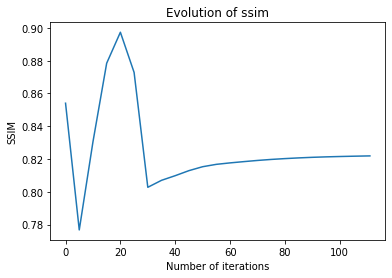

In [67]:
plt.plot(opt.metrics['ssim']['index'],opt.metrics['ssim']['values'])
plt.title("Evolution of ssim")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
#plt.savefig("Comparisons/db8/Condat/ssim_evolution.png")

good values: $\sigma=\tau=1$, $\epsilon=10^{-5}$, $\alpha\approx 10^{-6}$.